# Satellite image recogniton 

## Random Forest

https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html


https://github.com/ML-MachineLearning/randomforest-GA/blob/master/random_forest.ipynb

https://github.com/florianbeyer/RandomForest-Classification/blob/master/Classification_script.ipynb


## Read dataset

In [1]:
import numpy as np
import os
from tensorflow.keras import layers
import keras
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
from PIL import ImageOps
from PIL import Image 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix 
import pandas as pd

import seaborn as sn

import datetime

### read variables in mmap mode to save memory 

In [2]:
input_dat = np.load(os.path.join('../data_fin/train_input_dat.npy'), mmap_mode='r')
target_dat = np.load(os.path.join('../data_fin/train_target_dat.npy'), mmap_mode='r')

In [3]:
train_input_dat=input_dat[1500:,:,:,:]
train_target_dat=target_dat[1500:,:,:,:]

val_input_dat=input_dat[:1500,:,:,:]
val_target_dat=target_dat[:1500,:,:,:]



## What classes are in the dataset

### Entire dataset

In [ ]:
flat=np.argmax(target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Traing dataset

In [ ]:
flat=np.argmax(train_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Testing dataset

In [ ]:
flat=np.argmax(val_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

## Sample image and mask

(224, 224, 3)


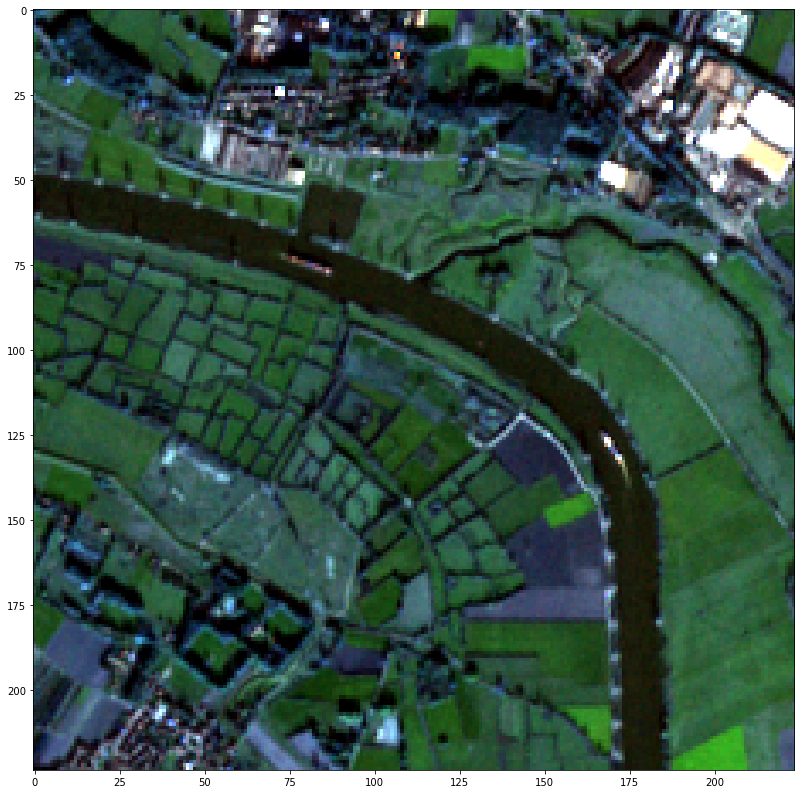

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


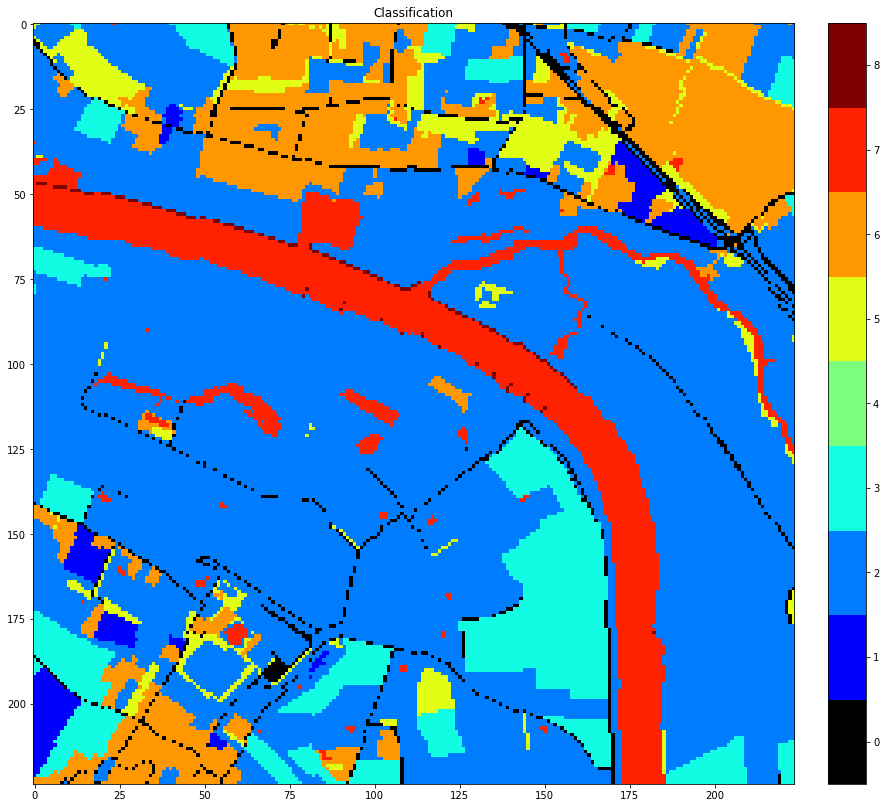

In [4]:

def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(15, 14)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(15, 14)
    plt.show()
    
    
    
    
# Display results for validation image #10
i = 78


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
    

## Convert shape of input and mask dataset

In [5]:
Y=np.argmax(train_target_dat, axis=-1).flatten()
X=train_input_dat.reshape(183593984,3)

In [6]:
X.shape

(183593984, 3)

## Decrease size of dataset to fit into memory

In [17]:
x=X[:1000000,:]
y=Y[:1000000]

## Random forest

In [18]:
# Fitting the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, 
                            oob_score=True, 
                            max_depth=9, 
                            n_jobs=-1, 
                            verbose=1,
                            bootstrap=True)

# Fit the model to training data
rf.fit(x, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished


RandomForestClassifier(max_depth=9, n_jobs=-1, oob_score=True, verbose=1)

## Model test

In [19]:
df = pd.DataFrame()
df['truth'] = Y[100000:200000]
df['predict'] = rf.predict(X[100000:200000])

df11=df['truth'] == df['predict']

tt=0
for i in range(df11.size):
    if df11[i]== True:
        tt=tt+1
print (tt)
print(' the percentage of recognition is  ', tt/df11.size)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


52097
 the percentage of recognition is   0.52097


## Save model in file

In [20]:
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict  0      2      3     5     6    7   8     All
truth                                                
0        1   5217   4427  1977   313   19  22   11976
1        0    121      0    95     0    0   0     216
2        0  32655  11671   877  2011  114  67   47395
3        0  16024  17975   500   676   13   0   35188
5        0   1001     78   667    54   18   0    1818
6        0    552    161   223   154    7   1    1098
7        0    668    154   357   480  645   5    2309
All      1  56238  34466  4696  3688  816  95  100000


## Plot confusion matrix 

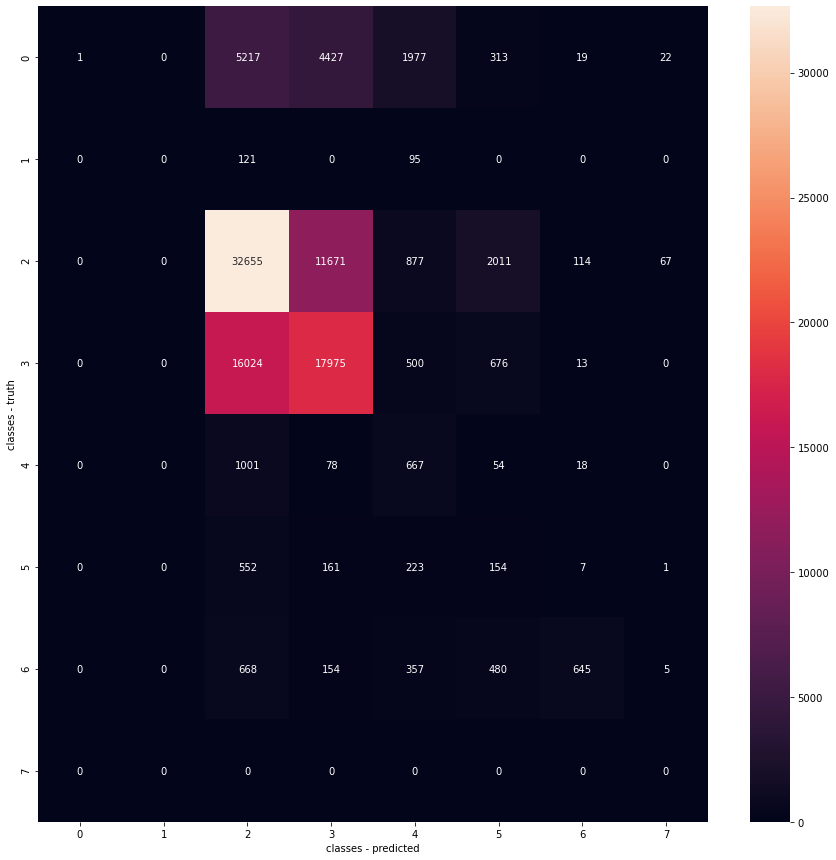

In [21]:
cm = confusion_matrix(df['truth'],df['predict'])
plt.figure(figsize=(15,15))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


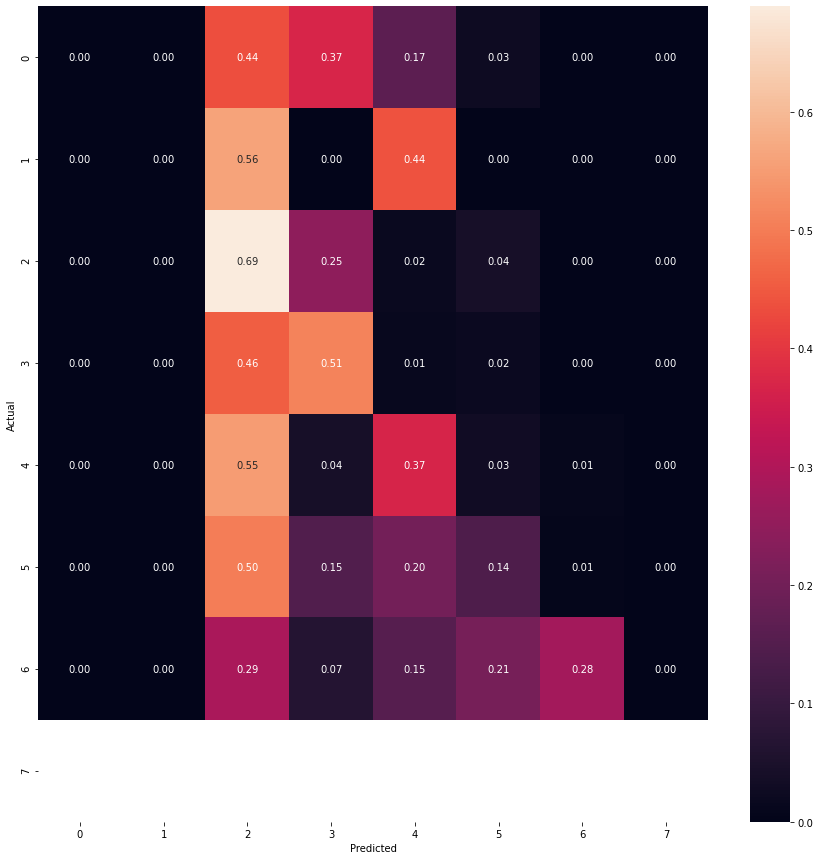

In [22]:
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Decrease dataset for Support Vector Machine

In [23]:
x=X[10000:30000,:]
y=Y[10000:30000]



## Support Vector Machine 

In [24]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x, y)

SVC()

## SVM test

In [25]:
df = pd.DataFrame()
df['truth'] = Y[30000:50000]
df['predict'] = clf.predict(X[30000:50000])

df11=df['truth'] == df['predict']
tt=0
for i in range(df11.size):
    if df11[i]== True:
        tt=tt+1
print (tt)
print(' percentage is ', tt/df11.size)

11300
 percentage is  0.565


In [26]:
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     0      2     3    5    6    All
truth                                      
0         645   1937   165  104  147   2998
1           7     14     0    0    0     21
2         685   8449   210  127   44   9515
3         382   1813  1579   11   23   3808
5         217     89     0   74    3    383
6        1066    491   418   72  553   2600
7         382    235     8   45    5    675
All      3384  13028  2380  433  775  20000


## Confusion matrix 

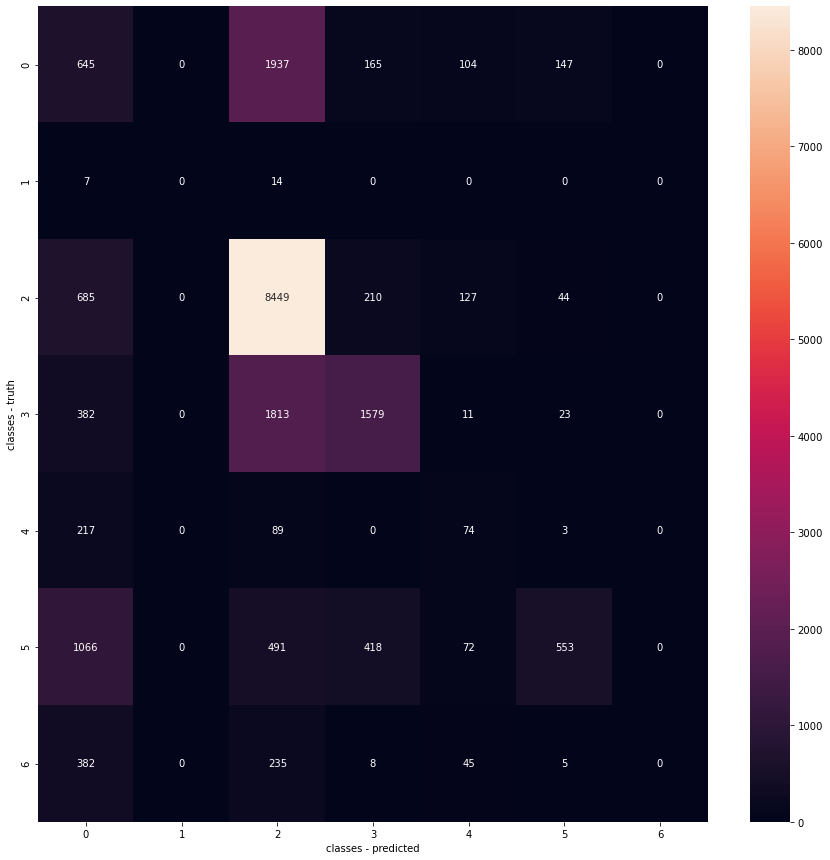

In [27]:
cm = confusion_matrix(df['truth'],df['predict'])
plt.figure(figsize=(15,15))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

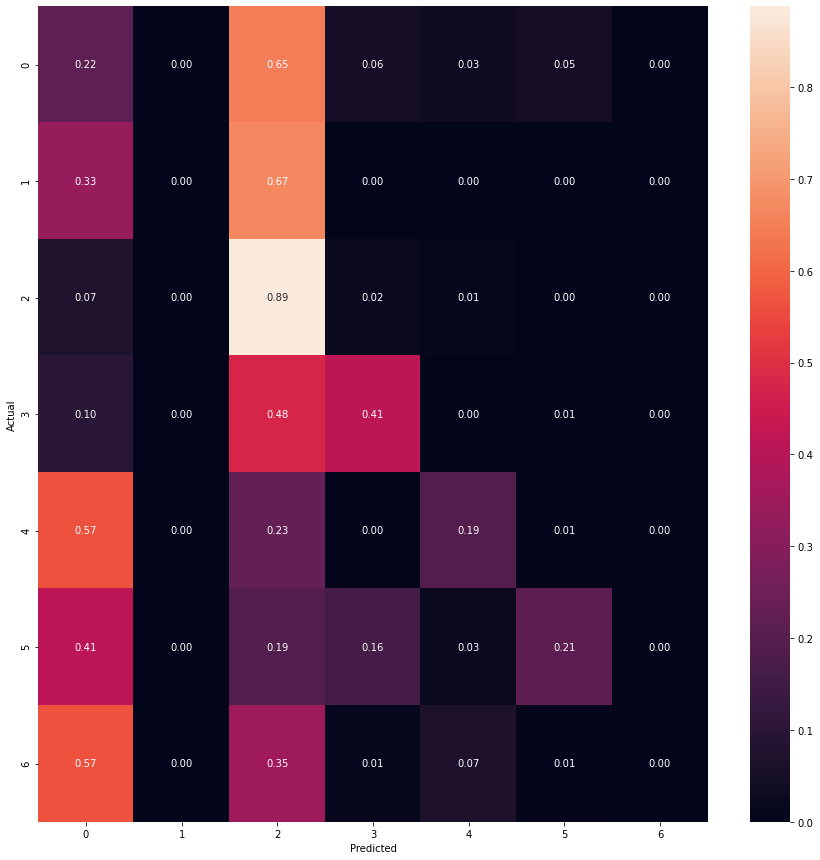

In [28]:
# Normalise
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Evaluate model

## Visualizing model performance
### Let's plot the model accuracy and loss for the training and the validating set. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

## Diagonal sum of confusion matrix

In [ ]:
sum=0
for i in range(0,cm.shape[0]):
    sum=sum+cm[i][i]
"{0:,.2f}".format(sum)

## Model Evaluate

## Visualize predictions

In [ ]:
Y_pred.shape

In [ ]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(10, 10)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    
# Display results for validation image #10
i = 15


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
# Display mask predicted by our model
#display_mask(i)  # Note that the model only sees inputs at 150x150.
display_target(Y_pred[i])


https://www.kaggle.com/meaninglesslives/unet-resnet34-in-keras